In [8]:
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.animation as animation

## 6.832: Problem Set #2

Due on Wednesday, February 27, 2019 at 17:00.  See course website for submission details. Use Drake release tag `drake-20190218`, i.e. use this notebook via `./docker_run_notebook.sh drake-20190218 .`, or whichever script you need for your platform.

---

## About this problem set

This problem set will entirely live inside this jupyter notebook.

Grades will be assigned based on three components:

- __Manually graded free-response questions__ -- the TAs will manually assign grades to your answers to short answer responses. You can write inline responses using [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet) with inline LaTeX -- double-click on any problem writeup to see some examples. Double-click response areas to edit them, and press Control-Enter to finish editing them.
- __Automated code testing__ -- we will run automated tests against specific functions (see more details when we introduce the first coding test).
- __Quick code review__ -- we will perform a quick manual check to make sure you have actually implemented the functions correctly (as opposed to hacked the unit tests to pass!).

The automated coding tests are pretty small in this problem set, but we are planning to move more towards this framework in the next three problem sets.  We would love to hear feedback from you on how this testing setup works.

---


# 1. Cost Functions


In this problem we will explore how to design cost functions that make the robot exhibit the kind of behavior we want. For this, we will consider the Dubins car model, which is a very simple model of a vehicle given by the following equations:

$$
{\bf{x}} = \left[ \begin{array}{c}
x \\
y \\
\psi \end{array} \right],
\ \ \ \ \ \ 
\dot{{\bf{x}}} = f({\bf{x}},u) = \left[ \begin{array}{c}
\dot x \\
\dot y \\
\dot \psi \end{array} \right] = \left[ \begin{array}{c} - \sin \psi \\
\cos \psi \\
u \end{array} \right],
$$

where $\bf{x}$ is the state of the system and consists of the states $x$ (the x-position), $y$ (the y-position) and $\psi$ (the yaw angle of the vehicle). 

The only control input is the steering angle $u$, which directly controls $\dot{\psi}$, while the car drives at constant velocity. (At $\psi=0$, the vehicle drives in the $+y$ direction.) $u$ has limits $[-u_{max}, +u_{max}]$.  

Note that this is a very simple model -- it does not follow Newtonian physics, and can instead just instantaneously choose its yaw rate.  It is however a simple model that has seen some use for actual robot research, for both UAVs and cars. [For example, here's some relevant results on Google Scholar.](https://scholar.google.com/scholar?hl=en&as_sdt=0%2C22&q=dubins+path+planning&btnG=)  To give us a little visual, here's a figure from a paper that uses a Dubins model for a 2D UAV in an environment with obstacles [Barry et al., 2012](http://groups.csail.mit.edu/robotics-center/public_papers/Barry12.pdf):

<p align="center">
  <img src="dubins.png" width="250"/>
</p>
<p style="text-align: center;">Figure: A dubins vehicle, navigating amonst polygonal obstacles.</p>

---

## Question 1.1 (2 points)

In general it is useful to have cost functions that penalize both the states along a trajectory, and also the final state:

$$
J = {\bf{x}}(t_f)^T Q_f {\bf{x}}(t_f) + \int_0^{t_f} g({\bf{x}} (t),{\bf{u}} (t)) \ dt 
$$

In this question let's look only at cost functions that only involve the final state.  A simple form for a cost function that penalizes only the final state of the robot is

$$
J = {\bf{x}}(t_f)^T Q_f {\bf{x}}(t_f)
$$

where $t_f$ is the final time and $Q_f$ is a symmetric positive semidefinite matrix of the appropriate size. Suppose we want the robot to end up with its yaw angle close to 0, but do not care about the final $x$ and $y$ positions. What should we choose $Q_f$ to be (remember to make sure it is symmetric and positive semidefinite)?

In [5]:
'''
Autograded answer for 1.1

Please implement this function so that the return argument 
satisfies the specification above.

Scroll to the end of the notebook to execute all tests for this notebook.
'''
import numpy as np

def get_Q_f_problem_1_1():
    Qf = np.zeros((3, 3))
    Qf[2][2] = 1
    return Qf

print get_Q_f_problem_1_1()

[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  1.]]


#### Short answer explanation for 1.1. Provide a brief justification of your choice of $Q_f$ in this cell.

Positive numbers in the diagonals and zeros elsewhere are positive definite. By setting Qf[2,2] to positive, the resulting cost looks like $J = yaw^2*Q_f[2,2]$


---

## Question 1.2  (2 points)

Now suppose we want the vehicle to end up close to the line $y = 0.5x$, but we do not care exactly where on this line and what yaw angle it ends up in. What should we choose $Q_f$ to be (remember to make sure it is symmetric and positive semidefinite)?

In [6]:
'''
Autograded answer for 1.2

Please implement this function so that the return argument 
satisfies the specification above.
'''

def get_Q_f_problem_1_2():
    Qf = np.zeros((3, 3))
    # YOUR CODE HERE TO SET Qf
    Qf= np.matrix([[1.,-2.,0],[-2.,4.,0],[0,0,0]])
    return Qf

print get_Q_f_problem_1_2()

[[ 1. -2.  0.]
 [-2.  4.  0.]
 [ 0.  0.  0.]]


#### Short answer explanation for 1.2. Provide a brief justification of your choice of $Q_f$ in this cell.

Ignoring yaw for simplicity. Since matrix is symmetric:
$$
{\bf{x^T}}Q_f{\bf{x}} = 
{\bf{x^T}}\begin{bmatrix}
a^2 & b \\
b & c^2
\end{bmatrix}{\bf{x}} =
(a^2x+by)x+(bx+c^2y)y = (ax)^2+2bxy+(cy)^2
$$
Since $Q_f$ is positive semidefinite, form should be sum of squares:
$$
(ax+cy)^2=(ax)^2+2bxy+(cy)^2\rightarrow b = ac
$$

Last contraint is that cost = 0 when $y=0.5x$:
$$
(2ay+cy)^2 = 0 \rightarrow c=-2a
$$
Let $a^2=1\rightarrow c^2 = 4, b = -2$

## Question 1.3  (3 points)

Now suppose we want to end up close to the curve $y = x^2$, and again do not care about the final yaw angle or where exactly on this curve we end up. Why is it not possible to set $Q_f$ to achieve this?

#### Short answer explanation for 1.3. Please put your answer to this question in this cell. 

In the last question, in order for the cost to be 0 along $y = 0.5x$, $$
Q_f\begin{bmatrix}1\\0.5\end{bmatrix}x=\begin{bmatrix}0\\0\end{bmatrix}
$$
Which means that eigenvector $[1,0.5]^T$ (points along $y=0.5x$) has eigenvalue of 0 (get mapped to origin). However for a linear matrix $Q_f$, it's impossible to map points along nonlinear fn $y=x^2$ to origin without trivial 0 matrix.

---

# 2. Optimal Control via HJB

Consider the scalar equation
$$
\dot{x} = -4x + 2u,
$$
and the infinite horizon cost function 
$$
J = \int_0^{\infty} [32x^2 + u^2] dt.
$$

## Question 2.1  (5 points)

Assume that the optimal cost-to-go function is of the form $J^\star = px^2$. What value of $p$ satisfies the Hamilton-Jacobi-Bellman conditions for optimality?

#### Written answer explanation for 2.1. A proper answer to this question involves writing out more than a couple expressions.  We recommend working through this problem on pencil and paper first.  Please then write your answer below in this cell, using LaTeX-style math expressions.

Derivation:
HJB: 
$$0 = min_u[g(x,u) + \dfrac{\partial J^\star}{\partial x} f(x,u)]$$

given assumption of optimal cost-to-go: 
$$\dfrac{\partial J^\star}{\partial x} = 2px$$

plugging in gives optimal $u$ in terms of $p$ : 
$$min_u[32x^2+u^2+2px(-4x+2u)]$$

Because 
$$\dfrac{\partial}{\partial u}[...]=4px+2u=0$$

$u = -2px$

To determine p, plug back into HJB eqn:
$$ 32x^2+(-2px)^2+2px(-4x-4px) = -4p^2 -8p+32=0$$
$$p=[2,-4]$$

throw  away $p = -4$ since it results in unstable soln.

Answer:
$$ p = 2$$
Note: could have also solved without $J^*$ guess since it's form of LQR problem.

## Question 2.2 (3 points)

Given that the optimal feedback controller associated with $J^\star$ is $u^\star = -Kx$, what is the value of $K$?

#### Written answer explanation for 2.2. We recommend working through this problem on pencil and paper first.  Please then write your answer below in this cell, using LaTeX-style math expressions.

Based on solution to 2.1, $u=-2px$. Given $p=2$;

$$ K = 4$$

# 3. Typing in the Optimal Controller for the Double Integrator

In this problem, we'll consider the optimal control problem for the 1-dimensional input-constrained double integrator described by

$$
\ddot{q} = u, \ |u| \leq 1
$$

<p align="center">
  <img src="double_integrator.png" width="450"/>
</p>    
<p style="text-align: center;">Figure: Simple drawing of a double integrator</p>


As you may remember, a simple way to think of the double integrator is as a system which has direct control over its acceleration, like a brick sliding around on ice, with a rocket booster attached for control.  While a double integrator (especially in just 1 dimension) is a very simple system, double or triple integrators (which control jerk, the derivative of acceleration) can be for example used as [simple models (see Fig. 2) to approximate the dynamics of quadrotors](http://groups.csail.mit.edu/robotics-center/public_papers/Florence16.pdf)) for [performing obstacle avoidance and planning paths](https://www.youtube.com/watch?v=9a0eEscz1Cs&t=1s).

We won't often be able to simply type in an optimal controller, but for the double integrator, it's not too hard!

---

For this question, we want the optimal controller for a minimum-time cost function.  Remember that for "minimum-time" problems, we just have the cost function:

$$ J = \int_0^{\infty} g(x(t),u(t)) \ dt $$

for just:

$$ g(x,u) = \begin{cases}
      0, & \text{if}\ x = 0 \\
      1, & \text{otherwise}
    \end{cases} $$
    
Which gives us:

$$ J = t_f $$

Where $t_f$ is the time needed to reach the desired state, 0.  So our cost function is just the time needed to reach 0.


## Question 3.1 (4 points)

Implement the optimal controller, and the optimal cost-to-go function, for the double integrator in the space below.  (May help to look in the course notes at Example 8.2)

The point of this question isn't to practice our ability to implement algorithms, but instead to give us some data and experience to later make some interesting comparisons and analyses.

Also you can rest well knowing that no-one will ever have a "more optimal" controller than you!  (But actually, this maybe isn't the best controller.  We'll discuss why.)

In [14]:
'''
Autograded answer for 3.1

Please implement this function so that the return argument 
satisfies the specification above.
'''

def get_optimal_time_to_go_problem_3_1(q, qdot):
    #derived from class notes by looking closed form solution of phase plane when U is saturated
    if((qdot<0 and q <= 0.5*qdot**2) or (qdot>=0 and q < -0.5*qdot**2)):
        t = 2*np.sqrt(0.5*qdot**2 - q) - qdot
    elif(q == 0 and qdot == 0):
        t = 0
    else:
        t = 2*np.sqrt(0.5*qdot**2 + q) + qdot
    return t

def get_optimal_control_problem_3_1(q, qdot):
    if((qdot<0 and q <= 0.5*qdot**2) or (qdot>=0 and q < -0.5*qdot**2)):
        u = 1
    elif(q == 0 and qdot == 0):
        u = 0
    else:
        u = -1
        
    # Remember that the problem statement imposes constraints on u!
    return u

### Plotting help for Question 3.1

We've written a little plotting code for you to visualize this policy:

<IPython.core.display.Javascript object>


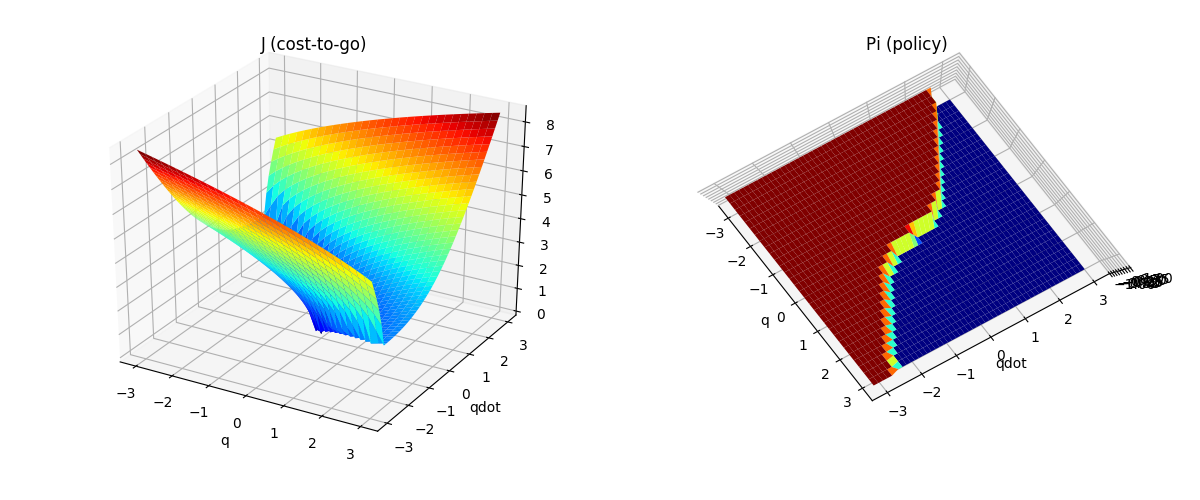

In [15]:
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.animation as animation

num_q_bins = 31
qbins = np.linspace(-3., 3., num_q_bins)
num_qdot_bins = 51
qdotbins = np.linspace(-3., 3., num_qdot_bins)
state_grid = [set(qbins), set(qdotbins)]

[Q, Qdot] = np.meshgrid(qbins, qdotbins)

fig_optimal, (ax_J, ax_Pi) = plt.subplots(1, 2, figsize=(12,5))
ax_J.axis('off')
ax_Pi.axis('off')

ax_J = fig_optimal.add_subplot(121, projection='3d')
ax_J.set_title('J (cost-to-go)')
ax_J.set_xlabel("q")
ax_J.set_ylabel("qdot")

ax_Pi = fig_optimal.add_subplot(122, projection='3d')
ax_Pi.set_title('Pi (policy)')
ax_Pi.set_xlabel("q")
ax_Pi.set_ylabel("qdot")
plt.tight_layout()

J_optimal = np.zeros((num_qdot_bins, num_q_bins))
for i, row in enumerate(J_optimal):
    for j, val in enumerate(row):
        J_optimal[i,j] = get_optimal_time_to_go_problem_3_1(Q[i,j], Qdot[i,j])
    
J_surface = [ax_J.plot_surface(Q, Qdot, J_optimal, rstride=1, cstride=1,
                       cmap=cm.jet)]

Pi_optimal = np.zeros((num_qdot_bins, num_q_bins))
Pi_optimal = np.zeros((num_qdot_bins, num_q_bins))
for i, row in enumerate(Pi_optimal):
    for j, val in enumerate(row):
        Pi_optimal[i,j] = get_optimal_control_problem_3_1(Q[i,j], Qdot[i,j])

Pi_surface = [ax_Pi.plot_surface(Q, Qdot, Pi_optimal, rstride=1, cstride=1,
                        cmap=cm.jet)]
plt.show()

Note that the plotting code, for both J and Pi, is just based on a 3D mesh over a `np.meshgrid` of Q and Qdot.

We recommend printing out these inputs to the plots, and practice manipulating the data of the plots.

In [5]:
# Some examples of interacting with the data generated above
print qbins.shape
print qdotbins.shape
print Q.shape
print Qdot.shape
print J_optimal.shape
print Pi_optimal.shape

terrible_control_choice = -Pi_optimal
qbin_sample = 10
qdotbin_sample = 3
print terrible_control_choice[qdotbin_sample][qbin_sample]

q = qbins[qbin_sample]
qdot = qdotbins[qdotbin_sample]
print -get_optimal_control_problem_3_1(q,qdot)

# Recommend investigating more the shapes of some of these and how they relate

(31,)
(51,)
(51, 31)
(51, 31)
(51, 31)
(51, 31)
-1.0
-1


## Question 3.2 (1 point)

For a real robot, why would the minimum-time solution not necessarily be the "best" thing to do?

#### Written answer explanation for 3.2. 

Minimum time often involves saturating actuators which may not be energy efficient and could make the system less robust to disturbances. It also doesn't allow penalties to overshooting etc. In general optimal solutions may be less robust than 'non-optimal' solutions.

# 4. Value Iteration solution for the Double Integrator

Now let's approach the same problem, but solve it using the Value Iteration algorithm. 

An implementation of that algorithm is available for you in Drake. This is a complete implementation of the algorithm with discrete actions and volumetric interpolation over state. 

In [6]:
import math
import numpy as np

from pydrake.systems.framework import VectorSystem
from pydrake.systems.analysis import Simulator
from pydrake.systems.controllers import (
    DynamicProgrammingOptions, FittedValueIteration)

# This system block implements the dynamics
# of a double integrator. It takes one control
# input, has two states (1D position and velocity),
# and copies its current state as its output.
class DoubleIntegrator(VectorSystem):
    def __init__(self):
        # One input, one output, two state variables.
        VectorSystem.__init__(self, 1, 1)
        self._DeclareContinuousState(2)

    # qddot(t) = u(t)
    def _DoCalcVectorTimeDerivatives(self, context, u, x, xdot):
        xdot[0] = x[1]
        xdot[1] = u

    # y(t) = x(t)
    def _DoCalcVectorOutput(self, context, u, x, y):
        y[:] = x

# Set up a simulation of this system.
plant = DoubleIntegrator()
simulator = Simulator(plant)
options = DynamicProgrammingOptions()

# This function evaluates a minimum time
# running cost, given a context (which contains
# information about the current system state).
def min_time_cost(context):
    x = context.get_continuous_state_vector().CopyToVector()
    if x.dot(x) < .05:
        return 0.
    return 1.

# This function evaluates a running cost
# that penalizes distance from the origin,
# as well as control effort.
def quadratic_regulator_cost(context):
    x = context.get_continuous_state_vector().CopyToVector()
    u = plant.EvalVectorInput(context, 0).CopyToVector()
    return 2*x.dot(x) + 10*u.dot(u)

# Pick your cost here...
cost_function = min_time_cost
# cost_function = quadratic_regulator_cost

# This sets up the mesh of sample points over
# which we'll run the value iteration algorithm.
num_q_bins = 31
# this value doesn't converge:
# num_q_bins = 38
qbins = np.linspace(-3., 3., num_q_bins)

num_qdot_bins = 51
#this value doesn't converge:
# num_qdot_bins = 38
qdotbins = np.linspace(-3., 3., num_qdot_bins)
state_grid = [set(qbins), set(qdotbins)]

input_limit = 1.
input_grid = [set(np.linspace(-input_limit, input_limit, 9))]
timestep = 0.01

[Q, Qdot] = np.meshgrid(qbins, qdotbins)

# Recommend not increasing the max_iterations too much.  Another factor of 10 should be okay, if you want to wait.
max_iterations = 10000
J_iterations  = np.zeros((num_qdot_bins, num_q_bins, max_iterations))
Pi_iterations = np.zeros((num_qdot_bins, num_q_bins, max_iterations))

num_iterations = 0
def add_iteration_solve(iteration, mesh, cost_to_go, policy):
    global num_iterations, J_iterations, Pi_iterations
    num_iterations += 1
    if num_iterations >= max_iterations:
        raise RuntimeError("Solution did not converge within "+str(max_iterations)+" iterations.")
    
    J = np.reshape(cost_to_go, Q.shape)
    J_iterations[:,:,iteration-1] = J    # "first" iteration here is "1", so here we 0-order it
    Pi = np.reshape(policy, Q.shape)
    Pi_iterations[:,:,iteration-1] = Pi
     
options.visualization_callback = add_iteration_solve

# Run value iteration on this mesh using
# the cost function chosen above. 
policy, cost_to_go = FittedValueIteration(simulator, cost_function,
                                          state_grid, input_grid,
                                          timestep, options)

# trim array of iterations
J_iterations  = J_iterations[:,:,:num_iterations]
Pi_iterations = Pi_iterations[:,:,:num_iterations]

print "Done solving.  Converged in "+str(num_iterations)+" iterations."

Done solving.  Converged in 1067 iterations.


Similar to before, it's useful to manipulate the data used to generate the plots.

Unlike with the analytical optimal policy, where we only had one mesh over $q$ and $\dot{q}$, this time we have saved the solution state from each solve.  Let's print out the shape of `Pi_iterations`.  Here we've set it up so that indexing into the last dimension gives us the solver at that iteration's state.

In [3]:
print Pi_iterations.shape

policy_on_10th_iteration = Pi_iterations[:,:,10]

final_computed_policy    = Pi_iterations[:,:,-1]

(51, 31, 1067)


### Now plot the result of Value Iteration

The above code cell already solved the value iteration code, and saved its iterative solution on each iteration.

Now below, we plot this solution over time.

<IPython.core.display.Javascript object>


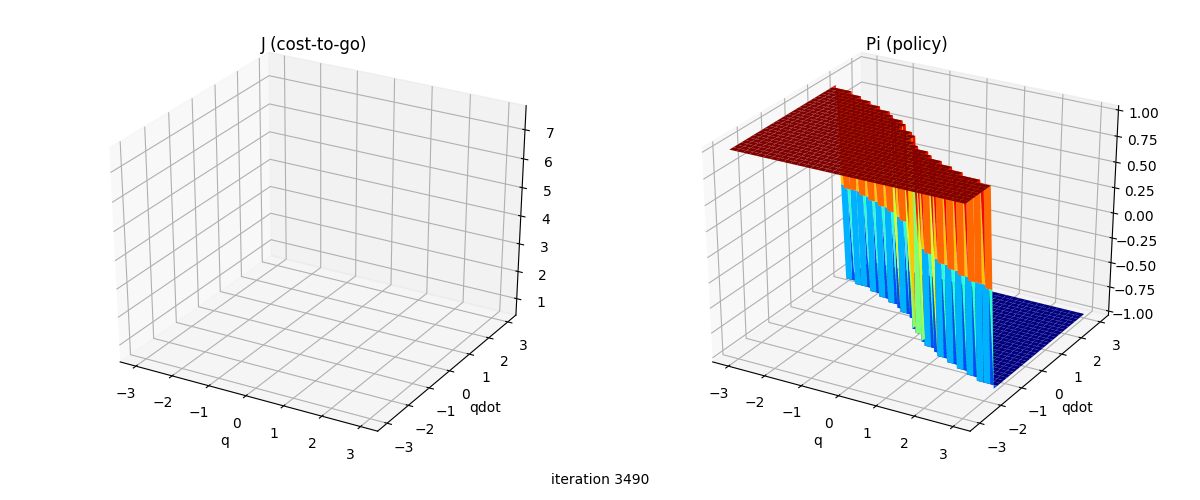

In [16]:
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.animation as animation

fig, (ax, ax2) = plt.subplots(1, 2, figsize=(12,5))
ax.axis('off')
ax2.axis('off')

ax = fig.add_subplot(121, projection='3d')
ax.set_title('J (cost-to-go)')
ax.set_xlabel("q")
ax.set_ylabel("qdot")

ax2 = fig.add_subplot(122, projection='3d')
ax2.set_title('Pi (policy)')
ax2.set_xlabel("q")
ax2.set_ylabel("qdot")
plt.tight_layout()

J_initial = J_iterations[:,:,0]
J_surface = [ax.plot_surface(Q, Qdot, J_initial, rstride=1, cstride=1,
                       cmap=cm.jet)]

Pi_initial = Pi_iterations[:,:,0]
Pi_surface = [ax2.plot_surface(Q, Qdot, Pi_initial, rstride=1, cstride=1,
                        cmap=cm.jet)]

def update_plots(iteration, J_iterations, J_surface, Pi_iterations, Pi_surface):
    if iteration % 10 != 0:
        return # only plot every 10th
    J_surface[0].remove()
    J_surface[0] = ax.plot_surface(Q, Qdot, J_iterations[:,:,iteration], rstride=1, cstride=1,
                        cmap=cm.jet)

    for txt in fig.texts:
        txt.set_visible(False)
    fig.text(0.5, 0.04, 'iteration '+str(iteration), ha='center', va='center')
    
    Pi_surface[0].remove()
    Pi_surface[0] = ax2.plot_surface(Q, Qdot, Pi_iterations[:,:,iteration], rstride=1, cstride=1,
                        cmap=cm.jet)
    

animate = animation.FuncAnimation(fig, update_plots, num_iterations, interval=1, fargs=(J_iterations, J_surface, 
                                                                            Pi_iterations, Pi_surface))

#### Tips

- while the animation is running, you can click + drag to change the 3D viewpoint

- pressing the "Power" button for the plot above will stop the animation, which is probably making your computer run pretty hard if you have it running

- restarting your jupyter notebook's kernel (the restart circle button up top in jupyter notebook) will also completely free up your system (but also lose all variable state)

---
Run the value iteration code for the double integrator to compute the optimal policy and optimal cost-to-go for the minimum-time problem. 

Compare the result to the analytical solution we found in lecture, and programmed in Question 3.1 by answering the following questions.

## Question 4.1 (5 points)

Find an initial condition of the form $(2, \dot{q}_0)$ such that the value iteration policy takes an action in exactly the wrong direction from the true optimal policy.

a) What value of $\dot{q}_0$ did you find that disagrees?

b) What is the true optimal time-to-go from this state (i.e., for the optimal bang-bang controller derived in class)?

c) What is the time-to-go estimated by value iteration?

d) Why are these values different?

#### Written answer explanation for 4.1.   Bonus points if you generate plots that help explain your answer.  (Feel free to add code cells, in addition to this markdown cell.)

a) Based on the plots below, value iteration differs from analytic policy near the policy switch between $\pm 1$. When $q_0 = -1.8$ and $q=2$, value iteration would command 1 but analytic solution would command -1.

b) As calculated below, the optimal time-to-go for this state is $2.005s$.

c) Estimated time to go is $2.86s$.

d) In this init state, a constant accel $u=1$ would be optimal since this state is near the $u=\pm 1$ threshold (i.e. mass is coming towards origin and all we have to do is brake). However, since the value iteration provides initially the wrong value, it would cause the mass to overshoot the origin. This would require extra time to fix at the end.

<IPython.core.display.Javascript object>


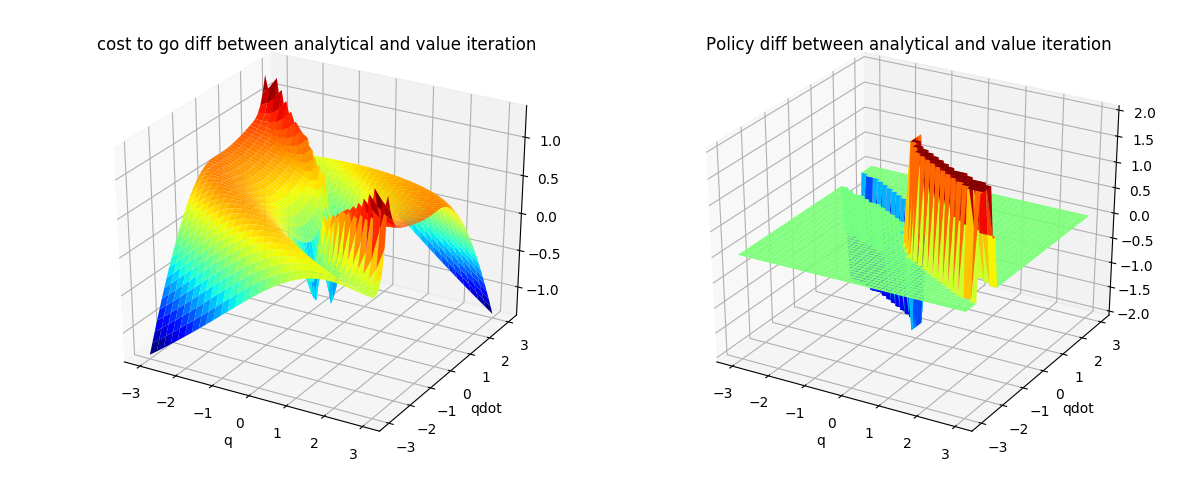

Error in policy of 2.0, cost-to-go of 0.851244241498, when q=2.0 and qdot=-1.8
True optimal time to go = 2.00525951809 sec
Value it. estimated time to go = 2.85650375959 sec


In [14]:
 #4a solution code:
cost_to_go_diff = J_iterations[:,:,-1] - J_optimal
policy_diff = Pi_iterations[:,:,-1] - Pi_optimal


fig_optimal, (ax_J_diff, ax_Pi_diff) = plt.subplots(1, 2, figsize=(12,5))
ax_J_diff.axis('off')
ax_Pi_diff.axis('off')

ax_J_diff = fig_optimal.add_subplot(121, projection='3d')
ax_J_diff.set_title("cost to go diff between analytical and value iteration")
ax_J_diff.set_xlabel("q")
ax_J_diff.set_ylabel("qdot")

ax_Pi_diff = fig_optimal.add_subplot(122, projection='3d')
ax_Pi_diff.set_title('Policy diff between analytical and value iteration')
ax_Pi_diff.set_xlabel("q")
ax_Pi_diff.set_ylabel("qdot")
plt.tight_layout()

ax_J_diff.plot_surface(Q, Qdot, cost_to_go_diff, rstride=1, cstride=1,
                        cmap=cm.jet)

ax_Pi_diff.plot_surface(Q, Qdot, policy_diff, rstride=1, cstride=1,
                        cmap=cm.jet)

plt.show()

print "Error in policy of {}, cost-to-go of {}, when q={} and qdot={}".format(policy_diff[10,25],cost_to_go_diff[10,25],qbins[25],qdotbins[10])
print "True optimal time to go = {} sec".format(J_optimal[10,25])
print "Value it. estimated time to go = {} sec".format(J_iterations[10,25,-1])


## Question 4.2 (3 points)
    
When implementing value iteration, one needs to be wary of several implementation details. 

Find a setting of the discretization (i.e., the variables `num_q_bins` and `num_qdot_bins`) that causes the code to NOT converge in 10,000 iterations.

The [underlying implementation](https://github.com/RobotLocomotion/drake/blob/master/systems/controllers/dynamic_programming.cc) of value iteration terminates after performing an update to J* (following the discrete value iteration update described in class) and finding that the update did not change J* by more than $\epsilon = 0.0001$ at any point. 

Why doesn't the setting you discovered converge?

*Note: The maximum distance between points in the $q$ and $\dot{q}$ directions should still be at most 0.2, and the grid must still contain the square with sides of length 2 centered about the origin.*


#### Short answer for 4.2. 
Seems like any setting with `num_q_bins = num_qdot_bins = even number AND <= 42` causes a failed convergence. The animation shows that while $J^*$ converges to a shape, it has a continually increasing constant offset which is what prevents convergence. This also conforms with the theory: value iteration garuntees convergence of the cost-to-go up to a uniform factor $\hat{J}^*=J^*+c$. A possible explanation for why this is happening is that low value, even numbered bins means the origin (goal state) is not included in the mesh. This could cause mesh points near goal to still have non-zero cost accumulation.

## Question 4.3 (2 points)

We may have noticed some issues for the value iteration solution, compared to what we know is the optimal solution. But it's worth taking a moment to consider the pros and cons of each method we've tried so far:

a) What is at least one reason that the value iteration algorithm is powerful, compared to the analytical solution?

b) On the other hand, what is nice about the analytical solution?

#### Short answers for 4.3. 

a) Value iteration can easily be applied to any system with various cost functions and dynamics and doesn't require physical intuition. However, it isn't feasible for systems with many degrees of freedom (like >6) and often requires very fine mesh around complex dynamics.

b) Analytical solution doesn't suffer from numerical errors/ errors near the boundary and can be less computationally expensive to calculate. However this is usually only possible for extremely simple systems.

## Question 4.4 (2 points)

Switch the cost function for the double integrator so that we use a quadratic cost on both: control input, and state. This has already been implemented for you as: `quadratic_regulator_cost()`.

How does the minimum-time solution of value iteration compare to the quadratic-regulator solution?

#### Short answer for 4.4. 

The code below compares the solutions for both quadratic and min time cost fns. For states farther from the switching policy logic, the quadratic cost sill saturates the policy. However, closer to the switching logic the magnitude of the policy with quadratic cost is no longer bang-bang (somewhere in between).

In [5]:
# This function evaluates a running cost
# that penalizes distance from the origin,
# as well as control effort.
def quadratic_regulator_cost(context):
    x = context.get_continuous_state_vector().CopyToVector()
    u = plant.EvalVectorInput(context, 0).CopyToVector()
    return 2*x.dot(x) + 10*u.dot(u)

# Pick your cost here...
cost_function = quadratic_regulator_cost

[Q, Qdot] = np.meshgrid(qbins, qdotbins)

J_iterations_quadCost  = np.zeros((num_qdot_bins, num_q_bins, max_iterations))
Pi_iterations_quadCost = np.zeros((num_qdot_bins, num_q_bins, max_iterations))

num_iterations = 0
def add_iteration_solve(iteration, mesh, cost_to_go, policy):
    global num_iterations, J_iterations_quadCost, Pi_iterations_quadCost
    num_iterations += 1
    if num_iterations >= max_iterations:
        raise RuntimeError("Solution did not converge within "+str(max_iterations)+" iterations.")
    
    J = np.reshape(cost_to_go, Q.shape)
    J_iterations_quadCost[:,:,iteration-1] = J    # "first" iteration here is "1", so here we 0-order it
    Pi = np.reshape(policy, Q.shape)
    Pi_iterations_quadCost[:,:,iteration-1] = Pi
     
options.visualization_callback = add_iteration_solve

# Run value iteration on this mesh using
# the cost function chosen above. 
policy, cost_to_go = FittedValueIteration(simulator, cost_function,
                                          state_grid, input_grid,
                                          timestep, options)

# trim array of iterations
J_iterations_quadCost  = J_iterations_quadCost[:,:,:num_iterations]
Pi_iterations_quadCost = Pi_iterations_quadCost[:,:,:num_iterations]

print "Done solving.  Converged in "+str(num_iterations)+" iterations."

Done solving.  Converged in 2438 iterations.


<IPython.core.display.Javascript object>


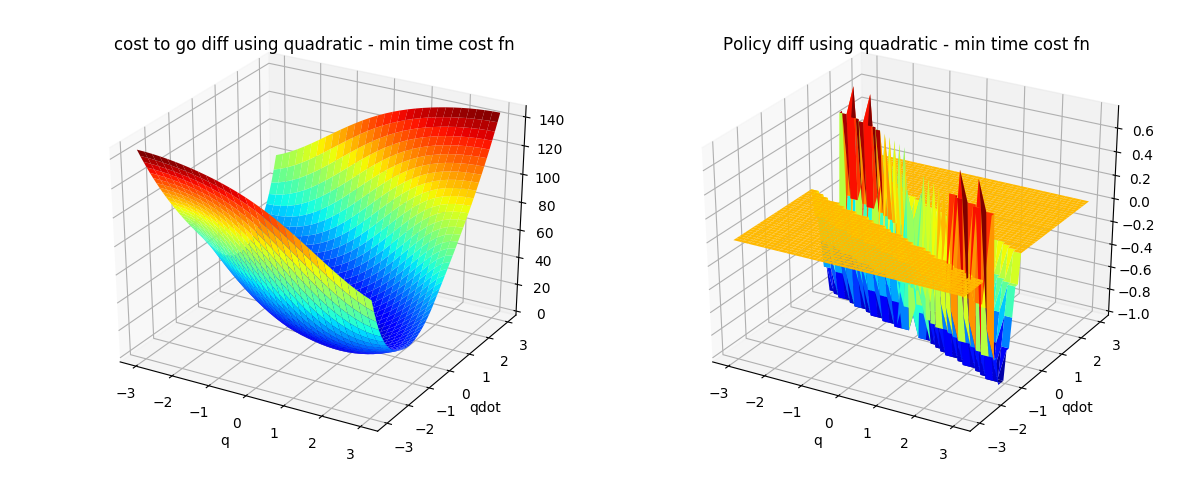

In [20]:
 #4.4 solution code:
cost_to_go_diff = J_iterations_quadCost[:,:,-1]-J_iterations[:,:,-1]
policy_diff = np.abs(Pi_iterations_quadCost[:,:,-1]) - np.abs(Pi_iterations[:,:,-1])


fig_optimal, (ax_J_diff, ax_Pi_diff) = plt.subplots(1, 2, figsize=(12,5))
ax_J_diff.axis('off')
ax_Pi_diff.axis('off')

ax_J_diff = fig_optimal.add_subplot(121, projection='3d')
ax_J_diff.set_title("cost to go diff using quadratic - min time cost fn")
ax_J_diff.set_xlabel("q")
ax_J_diff.set_ylabel("qdot")

ax_Pi_diff = fig_optimal.add_subplot(122, projection='3d')
ax_Pi_diff.set_title('Policy diff using quadratic - min time cost fn')
ax_Pi_diff.set_xlabel("q")
ax_Pi_diff.set_ylabel("qdot")
plt.tight_layout()

ax_J_diff.plot_surface(Q, Qdot, cost_to_go_diff, rstride=1, cstride=1,
                        cmap=cm.jet)

ax_Pi_diff.plot_surface(Q, Qdot, policy_diff, rstride=1, cstride=1,
                        cmap=cm.jet)

plt.show()

---

Note: you can still receive full credit if you do not do the bonus questions.  But you may be able to get extra credit if you do them.

# 5. Bonus Question: Value Iteration for the simple pendulum

## Bonus 5.1 (2 points)

See if you run the value iteration example for the input-constrained pendulum. Either replicate the setup above we provided for the double integrator, or use the `bash` scripts provided for the docker image, i.e. run:

```
# or use the bash script for your system
./docker_run_bash_linux.sh drake-20190218. 
# now inside docker image
cd /underactuated/src
cd pendulum
python value_iteration.py
```

Question: how does the value-iteration solution compare to other control design methods we have explored for the input-constrained pendulum?

#### Short answer for 5.1. 

YOUR ANSWER HERE

## Test your own implementations

Running the cell below will run your implemented functions against unit tests.

Don't change the cell below, or the `test_set_2.py` file.  We will grade your implementations against the original files.

Make sure to __SAVE__ your notebook before running tests.  (File --> Save and Checkpoint, or use the hotkey which should be ctrl+s on linux, cmd+s on osx, etc)

In [25]:
import os
# Run the test in a subprocess, to make sure it doesn't open any plots...
os.popen("python test_set_2.py set_2.ipynb test_results.json")

# Print the results json for review
import test_set_2
print test_set_2.pretty_format_json_results("test_results.json")

Test Problem 1_1: 2.00/2.00.

Test Problem 1_2: 2.00/2.00.

Test Problem 3_1 Optimal Control Input: 2.00/2.00.

Test Problem 3_1 Time (Cost) To Go: 2.00/2.00.

TOTAL SCORE (automated tests only): 8.00/8.00



Note that many of the questions are not auto-graded, but will be graded manually! (Double-check you gave answers for each.)